In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers


Total number of ETFs: 33


In [3]:
data = pd.read_csv('../../dataProcessing/assets_wide_fill_minus_one.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
display(data)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,-1.000000,-1.000,-1.000000,42.619999,26.042212,-1.000000,-1.000000,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,-1.000000,27.664722,34.591938,33.707809,6.78375
2012-01-04,-1.000000,-1.000,-1.000000,42.509998,26.165096,-1.000000,-1.000000,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,-1.000000,27.328695,34.000530,33.888020,6.69750
2012-01-05,-1.000000,-1.000,-1.000000,41.509998,25.814005,-1.000000,-1.000000,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,-1.000000,26.831099,34.319885,33.472149,6.68250
2012-01-06,-1.000000,-1.000,-1.000000,41.349998,25.919331,-1.000000,-1.000000,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,-1.000000,26.462753,34.207520,33.070118,6.72625
2012-01-09,-1.000000,-1.000,-1.000000,42.189999,25.831558,-1.000000,-1.000000,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,-1.000000,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [3]:
def create_X_y_rolling(df, window_size):
    X, y, first_values = [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value  
        X.append(normalized_window.values)
        y_target = df.iloc[i+window_size] / first_value  
        y.append(y_target.values)
        first_values.append(first_value.values) 
    X = np.array(X)
    y = np.array(y)
    first_values = np.array(first_values)
    return X, y, first_values

window_size = 30
X, y, first_values = create_X_y_rolling(data, window_size)

In [4]:
dataset_size = len(X)
print(dataset_size)


train_size = int(dataset_size * 0.8)
test_size =int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size


X_train, X_val, X_test = X[:train_size], X[train_size: train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test= y[:train_size], y[train_size: train_size + val_size], y[train_size + val_size:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

first_values_test = first_values[train_size + val_size:]


3378


In [5]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  
    LSTM(64, return_sequences=False),  
    Dense(y_train.shape[1])  
])


model.compile(loss=MeanSquaredError(), 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

cp = ModelCheckpoint(filepath='model_regression/best.keras', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp, es],
)
# model.summary()



Epoch 1/100


c:\Users\Shelly\Desktop\KU\18_Bachelor_project\venv_project\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.3172 - mean_squared_error: 0.3171 - val_loss: 0.0060 - val_mean_squared_error: 0.0061
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0049 - val_mean_squared_error: 0.0050
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0049 - val_mean_squared_error: 0.0050
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0051 - val_mean_squared_error: 0.0050
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0042 - val_mea

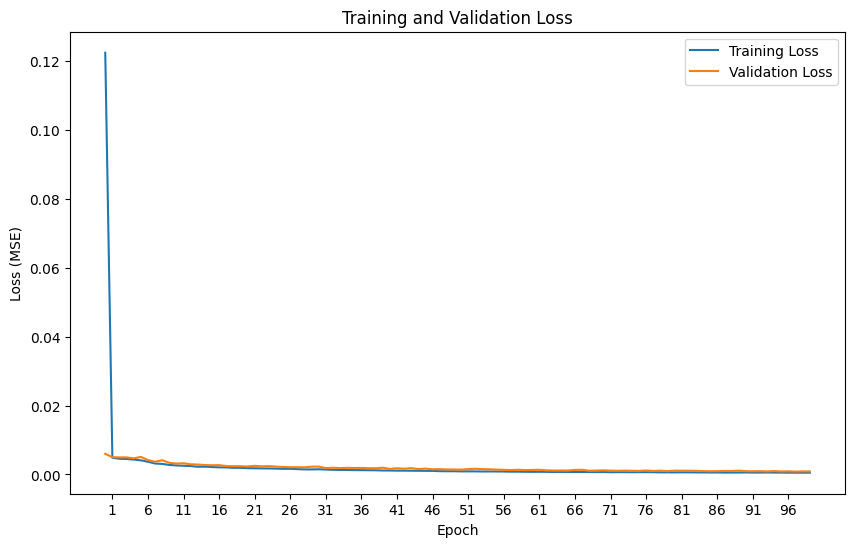

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 100, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


<Axes: xlabel='Date'>

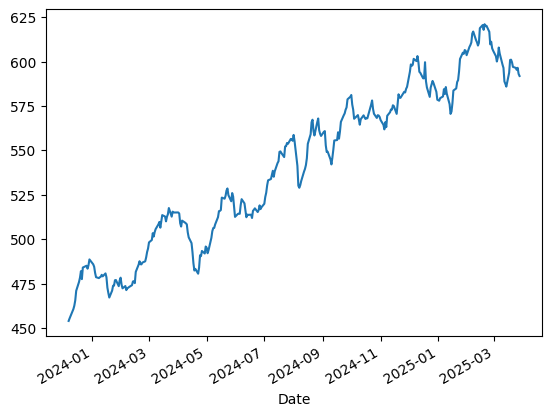

In [7]:
model = load_model('model_regression/best.keras')
index_series = data.index[train_size + val_size + window_size:]

Y_pred = model.predict(X_test)
Y_pred_denorm = Y_pred * first_values_test  

Predict_result_df = pd.DataFrame(Y_pred_denorm, index=index_series, columns=data.columns)

# display(Predict_result_df)

Predict_result_df["SPY"].plot()


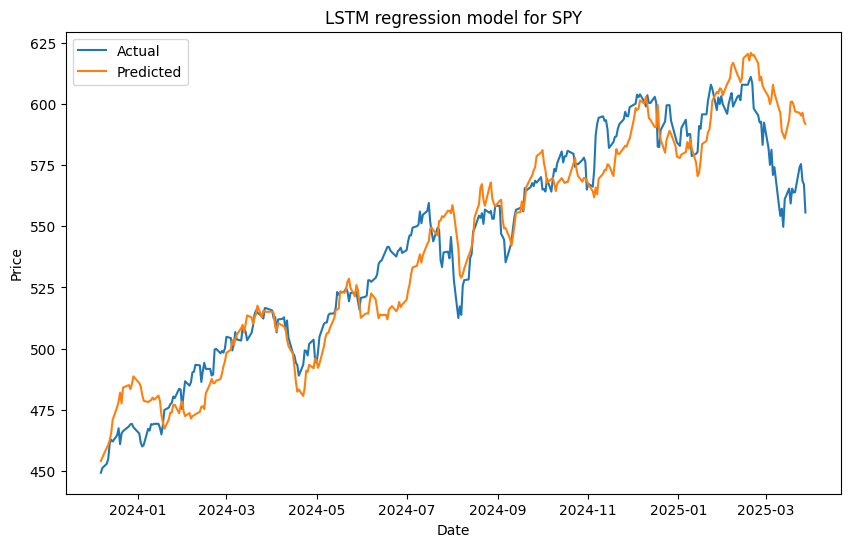

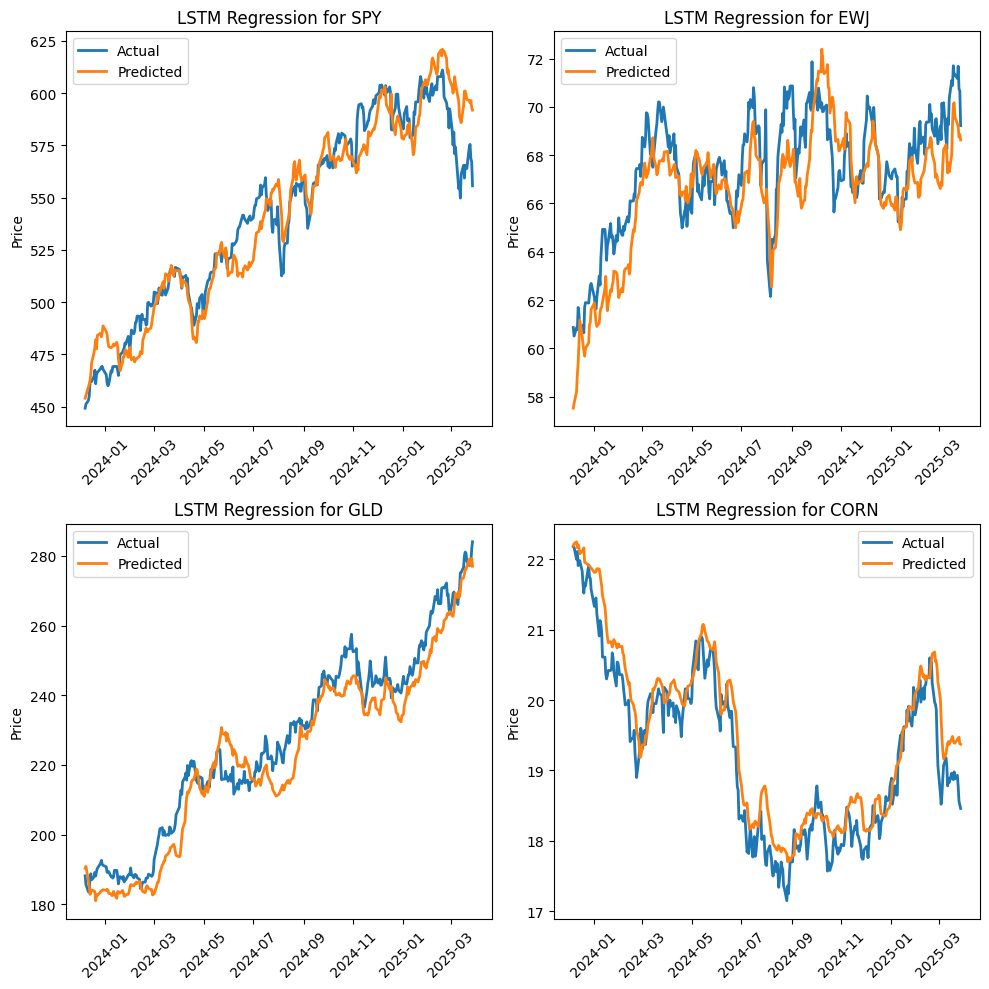

In [8]:
y_test_denorm = y_test * first_values_test
y_actual = pd.DataFrame(y_test_denorm, index=index_series, columns=data.columns)
ticker_name = 'SPY'

plt.figure(figsize=(10,6))
plt.plot(y_actual[ticker_name], label='Actual')
plt.plot(Predict_result_df[ticker_name], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM regression model for {ticker_name}')
plt.legend()
plt.show()


ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  # example tickers, adjust as needed

# Define layout
num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten()  # Flatten in case of single row

# Plot each ticker
for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Predict_result_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

# Remove any empty subplots if the number of tickers is less than the number of subplots
for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [10]:
print("Mean of actual normalized prices:", np.mean(y_test * first_values_test))
print("Mean of predicted normalized prices:", np.mean(Y_pred * first_values_test))


Mean of actual normalized prices: 70.92950751496116
Mean of predicted normalized prices: 70.76549578308132


In [11]:
target = (data > data.shift(1)).astype(int)
target_test = target.iloc[train_size + val_size + window_size:]
display(target_test)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,1,1,0,1,1,1,1,1,0,1,...,0,1,0,1,0,0,1,1,1,0
2023-12-08,1,0,1,0,1,0,0,1,1,1,...,0,1,0,1,1,1,1,0,0,0
2023-12-11,1,1,0,0,1,0,1,0,1,1,...,0,1,0,1,1,1,1,1,1,1
2023-12-12,0,0,1,1,0,0,0,1,0,1,...,0,1,1,0,0,1,1,0,1,0
2023-12-13,1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [ ]:
Predict_result_df


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,32.252792,9.145408,73.806537,22.194996,13.379220,106.985718,51.612577,20.765619,32.892140,26.897440,...,22.888872,454.025789,86.606286,66.189480,110.198881,110.698976,58.831245,76.428574,63.883087,6.342349
2023-12-08,32.307949,9.062845,74.416227,22.219544,13.406812,106.560293,51.844370,20.813619,32.755658,26.905551,...,22.699396,455.450184,86.714720,64.272416,111.179492,111.465409,58.797799,76.762316,63.982976,6.367318
2023-12-11,32.377188,8.996705,75.473734,22.248540,13.220683,106.930570,51.867607,21.045526,32.961955,26.897186,...,22.259039,459.456713,86.355786,64.812897,112.979477,111.245408,59.219627,77.456277,64.615883,6.270827
2023-12-12,32.745067,8.951019,76.199738,22.163706,13.276389,107.252687,51.892792,20.953869,32.792396,26.906482,...,21.830658,460.662999,85.637366,65.069684,114.260382,111.672111,59.338854,77.864885,65.067376,6.268936
2023-12-13,32.657304,8.942005,76.039523,22.205196,13.147765,106.165086,52.001231,21.005599,32.806948,26.977867,...,21.570813,462.599016,86.548961,64.416361,113.805352,111.388622,59.322529,77.749287,65.299546,6.235353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,36.953586,10.956695,97.186647,19.438483,13.694153,111.976689,54.400338,24.328735,41.565260,37.275189,...,29.807204,596.405455,86.370069,76.094045,122.872520,141.113008,70.951786,86.926482,73.512241,7.797066
2025-03-25,36.980046,10.922007,98.146933,19.462407,13.940696,112.260321,54.723081,24.451098,41.646281,37.343430,...,29.695486,595.304673,86.084181,77.139274,124.641310,141.359174,70.984209,87.429664,73.449227,7.855988
2025-03-26,37.567218,10.808700,99.252833,19.471854,14.014402,111.393195,54.894804,24.777102,42.023470,37.514745,...,29.960541,596.455320,85.533922,77.559919,125.789490,141.208059,71.249582,87.495132,73.391369,7.846669


In [14]:
y_test_shift = data[train_size + val_size + window_size-1:-1]
y_test_shift_index = data.index[train_size + val_size + window_size-1:-1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
display(y_test_shift_df)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-06,31.731205,8.900776,76.974998,22.000000,13.072258,103.731880,50.784622,21.313770,33.706150,28.072565,...,21.930000,445.846313,90.183121,64.760002,108.895752,109.613686,59.062138,78.568329,65.462090,6.55625
2023-12-07,32.058788,8.903205,76.775002,22.180000,13.127030,103.761421,51.063972,21.502892,33.686855,28.199457,...,21.790001,449.248260,89.665726,65.110001,108.342834,109.544876,59.272324,78.794044,66.030174,6.45375
2023-12-08,32.495575,8.876504,79.084999,22.170000,13.327862,103.751572,51.044708,21.578537,33.821918,28.306829,...,21.100000,451.179626,88.931999,66.529999,109.629784,109.987221,59.597153,78.662369,65.869217,6.37375
2023-12-11,32.841022,8.988158,76.050003,22.000000,13.455663,103.249550,51.256634,21.569082,33.889442,28.345873,...,20.910000,452.934509,88.743874,66.800003,109.696518,110.304230,59.683144,78.878693,66.143791,6.39750
2023-12-12,32.594837,8.949322,76.269997,22.110001,13.072258,102.501427,51.189201,21.625820,33.686855,28.404438,...,20.840000,455.003174,89.007271,64.250000,108.075897,110.886650,59.788239,78.831673,66.172195,6.38375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-21,37.417000,10.370000,97.320000,18.879999,13.870000,109.500000,56.130001,23.430000,40.880001,38.090000,...,30.020000,563.979980,89.709900,73.790001,127.452606,137.462494,71.779999,89.352127,74.650002,8.32000
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875


In [15]:
y_test_shift_array = y_test_shift_df.values

predicted_directions = (Predict_result_df.values > y_test_shift_array).astype(int)
print(f"shape of predicted_directions: {predicted_directions.shape}")
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
display(predicted_directions_df)


shape of predicted_directions: (337, 33)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,1,1,0,1,1,1,1,0,0,0,...,1,1,0,1,1,1,0,0,0,0
2023-12-08,1,1,0,1,1,1,1,0,0,0,...,1,1,0,0,1,1,0,0,0,0
2023-12-11,0,1,0,1,0,1,1,0,0,0,...,1,1,0,0,1,1,0,0,0,0
2023-12-12,0,0,1,1,0,1,1,0,0,0,...,1,1,0,0,1,1,0,0,0,0
2023-12-13,1,0,0,1,1,1,1,0,0,0,...,1,1,0,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,0,1,0,1,0,1,0,1,1,0,...,0,1,0,1,0,1,0,0,0,0
2025-03-25,0,1,0,1,0,1,0,1,1,0,...,0,1,0,1,0,1,0,0,0,0
2025-03-26,0,1,0,1,0,1,0,1,1,0,...,0,1,0,1,0,1,0,0,0,0


In [16]:
print(f"shape of target_test: {target_test.values.shape}")
accuracy = (predicted_directions == target_test.values).astype(int)
accuracy = accuracy.sum() / (337 * 33) * 100
print(f"Accuracy of the model: {accuracy:.2f}")

shape of target_test: (337, 33)
Accuracy of the model: 50.32


In [36]:
yesterday_prices = data.iloc[-2]  
today_prices_actual = data.iloc[-1] 
# display(Predict_result_df.tail(30))
Y_pred_mean = Predict_result_df.mean(axis=0)
# print(Y_pred_mean.values)
today_prices_predicted = pd.Series(Y_pred_mean.values.flatten(), index=data.columns)


comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_pred': today_prices_predicted,
})

tickers_names = data.columns

correct_list = []
for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]

    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)

    if sign_actual == sign_pred:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list

count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
# display(comparison_df)
save_df = pd.DataFrame()
save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
save_df['Today pred target'] = comparison_df['Today_pred'].apply(lambda x: round(x, 2))
save_df['Correct'] = comparison_df['Correct']
display(save_df)
save_df.to_csv('rnn_regression.csv', index=True)


Count of correct predictions: 23
accuracy: 0.696969696969697


,Yesterday actual,Today actual,Today pred target,Correct
AIEQ,37.66,36.85,36.88,1
ASHR.L,10.46,10.34,9.82,1
BCHN.L,97.08,92.71,94.85,1
CORN,18.51,18.46,19.52,0
DBO,14.13,13.97,14.06,1
EDEN,105.33,105.17,118.45,0
EMXC,56.11,55.18,56.85,0
EWA,23.75,23.47,24.08,0
EWC,41.25,40.57,38.23,1
EWG,37.59,37.39,31.51,1
